In [9]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import integrate
from scipy import interpolate
import math
from scipy import signal


# Data Stream Class
Class Data Stream is to hold an activities data.
It parses a csv.
It rotates, interpolates, and integrates data.

In [3]:
class Data_Stream:
    gps = np.asmatrix([0.0, 0.0, 0.0, 0.0])
    rot_vec = np.asmatrix([0.0, 0.0, 0.0, 0.0])
    mag = np.asmatrix([0.0, 0.0, 0.0, 0.0])
    gyro = np.asmatrix([0.0, 0.0, 0.0, 0.0])
    acc_with_grav = np.asmatrix([0.0, 0.0, 0.0, 0.0])
    
    acc_DRC = np.asmatrix([0.0, 0.0, 0.0, 0.0])
    vel_DRC = np.asmatrix([0.0, 0.0, 0.0, 0.0])
    dis_DRC = np.asmatrix([0.0, 0.0, 0.0, 0.0])
    
    acc_ERC = np.asmatrix([0.0, 0.0, 0.0, 0.0])
    vel_ERC = np.asmatrix([0.0, 0.0, 0.0, 0.0])
    dis_ERC = np.asmatrix([0.0, 0.0, 0.0, 0.0])
    
    frequency = 0.0
    time_period = 0.0
    
    var_codes = {1.0 : gps, 82.0 : acc_DRC, 84.0 : rot_vec}
    
    def __init__(self, filename, invert=False):
        self.var_codes = {1.0 : [], 82.0 : [], 84.0 : [], 3.0 : [], 4.0 : [], 5.0 : []}
        
        ##Parse file
        f=open(filename, "r")
        start_time = False
        for line in f:
            line = line.split(',')
            if(start_time == False):
                start_time = float(line[0])
            self.process_csv_line(start_time, line)
        self.var_codes[1.0] = np.delete(self.var_codes.get(1.0), (0), axis=0) #GPS cant be (0 0 0 0) at init
        for key, value in self.var_codes.items():
            self.var_codes[key] = np.concatenate(value)
        print("Parsed File")
        
        ##Convert longitude and latitutde of GPS sensor to meters
        self.var_codes[1.0] = self.convert_longlat_to_dis(self.var_codes.get(1.0))
        
        ##Interpolate rotation and acceleration so that they occur at the same time step
        new_time = self.var_codes.get(3.0)[:, 0] # Set timesteps to be that of the acceleration, as it has most readings
        for key, value in self.var_codes.items():
#             if(key != 1.0):
            irreg_var = value
            reg_varX = np.asmatrix(np.interp(new_time, np.ravel(irreg_var[:,0]), np.ravel(irreg_var[:,1])))
            reg_varY = np.asmatrix(np.interp(new_time, np.ravel(irreg_var[:,0]), np.ravel(irreg_var[:,2])))
            reg_varZ = np.asmatrix(np.interp(new_time, np.ravel(irreg_var[:,0]), np.ravel(irreg_var[:,3])))
            self.var_codes[key] = np.concatenate((new_time, reg_varX, reg_varY, reg_varZ), axis=1)
        print("Interpolated Samples")
        

        
        ##Set class members to matrices read from csv
        self.acc_DRC = self.var_codes.get(82.0)
        self.rot_vec = self.var_codes.get(84.0)
        self.gyro = self.var_codes.get(4.0)
        self.mag = self.var_codes.get(5.0)
        self.acc_with_grav = self.var_codes.get(3.0)
        self.gps = self.var_codes.get(1.0)
        
        # If device axis is wrong, invert data
        self.invert_acceleration()
        
        ##Use rotation vectors to achieve acceleration in ERC        
        self.acc_ERC = self.rotate_acceleration(self.rot_vec, self.acc_DRC)
        print("Rotated Acceleration")
        
        ##Integrate each acceleration to calculate velocity and displacement
        self.integrate_variables()
        print("Integrated Acceleration")
        
        #Calculate Acc_DRC frequency
        self.time_period = np.mean(np.diff(self.acc_ERC[:, 0].T))
        self.frequency = 1/self.time_period
        
    def invert_acceleration(self):
        for i in self.acc_DRC:
            i[0, 1] *= -1
            i[0, 2] *= -1
    
    def process_csv_line(self, start_time, line):
        i = 1
        while(i < len(line)):
            if(float(line[i]) in self.var_codes):
                self.var_codes[float(line[i])].append(
                    np.asmatrix([float(line[0])-start_time, float(line[i+1]), float(line[i+2]), float(line[i+3])]))
            if(float(line[i]) == 8.0):
                i+=2
            else :
                i+=4
                
    def integrate_variable(self, var):
        return np.concatenate((self.acc_DRC[:,0], integrate.cumtrapz(var[:,1:4], initial=0, axis=0)), axis=1)
    def integrate_variables(self):
        self.vel_DRC = self.integrate_variable(self.acc_DRC)
        self.dis_DRC = self.integrate_variable(self.vel_DRC)
        
        self.vel_ERC = self.integrate_variable(self.acc_ERC)
        self.dis_ERC = self.integrate_variable(self.vel_ERC)
    def rotate_acceleration(self, rot_vectors, acc_vectors):
        acc_ERC = acc_vectors[:, 0]
        acc_ERC_list=[]
        for i in range(rot_vectors[:, 0].shape[0]):
            rot_matrix_inv = self.get_rotation_matrix(rot_vectors[i, 1:4]) #Orthogonal so transpose is inverse
            acc_ERC_list.append(np.matmul(rot_matrix_inv, acc_vectors[i, 1:4].T).T)        

        return np.concatenate((acc_ERC, np.concatenate(acc_ERC_list)), axis=1)
    
    def get_rotation_matrix(self, rot_vec):
        qx = rot_vec[0, 0]
        qy = rot_vec[0, 1]
        qz = rot_vec[0, 2]
        qw = 1 - qx**2 - qy**2 - qz**2
#         qw = math.sqrt(max(qw, 0))

        rot_matrix = np.asmatrix([1-2*qy**2-2*qz**2, 2*qx*qy-2*qz*qw, 2*qx*qz+2*qy*qw])
        rot_matrix = np.concatenate((rot_matrix, np.asmatrix([2*qx*qy+2*qz*qw,  1-2*qx**2-2*qz**2, 2*qy*qz-2*qx*qw])),
                                    axis=0)
        rot_matrix = np.concatenate((rot_matrix, np.asmatrix([2*qx*qz-2*qy*qw, 2*qy*qz+2*qx*qw, 1-2*qx**2-2*qy**2])),
                                    axis=0)
        return rot_matrix
    
    def convert_longlat_to_dis(self, gps):
        dis_list = [np.asmatrix([gps[0, 0], 0.0, 0.0, gps[0, 3]])]
        start_gps = gps[0]
        for i in range(1, gps.shape[0]-1): ## SWAP X and Y as in wrong order from stream
            dis_list.append(np.asmatrix([
                                gps[i, 0],
                                self.get_arc_len(start_gps[2], gps[i, 2]),
                                self.get_arc_len(start_gps[1], gps[i, 1]),
                                gps[i, 3]]))
        return np.concatenate(dis_list)
    
    def get_arc_len(self, deg1, deg2):
        delta_theta = deg2 - deg1
        delta_theta = ((delta_theta+180)%360)-180
        earth_R = 6378100
        return 2.0*math.pi*earth_R*delta_theta/360.0
        
        
        
        

In [4]:
data = Data_Stream("Data/data5.csv")
print(data.acc_DRC.shape)

Parsed File
Interpolated Samples
Rotated Acceleration
Integrated Acceleration
(4760, 4)


## Plot each variable on a graph

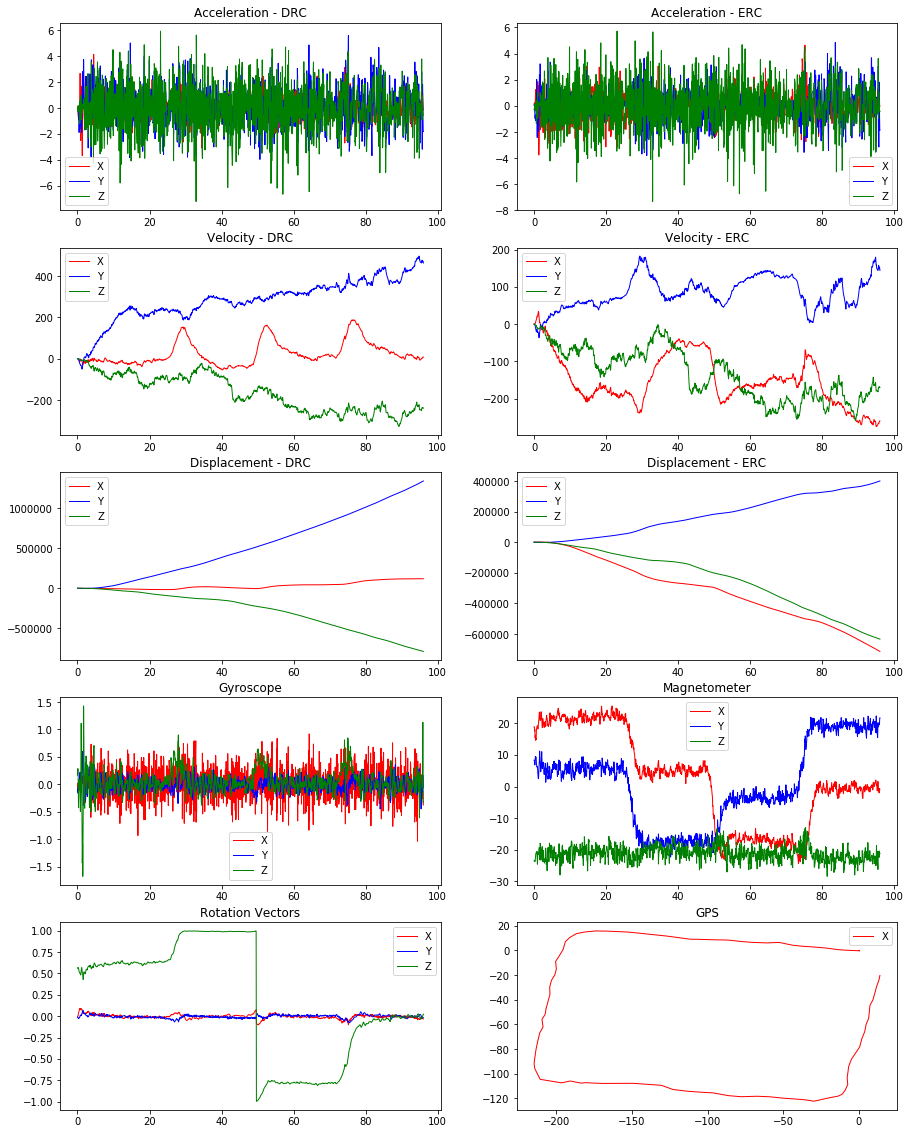

In [5]:
def plot_data(data):
    # Graph the variables.
    plt.figure(figsize=(15, 20))
    ax=plt.subplot(521)
    plt.plot(data.acc_DRC[:, 0], data.acc_DRC[:, 1], 'r-', lw=1, label='X')
    plt.plot(data.acc_DRC[:, 0], data.acc_DRC[:, 2], 'b-', lw=1, label='Y')
    plt.plot(data.acc_DRC[:, 0], data.acc_DRC[:, 3], 'g-', lw=1, label='Z')
    plt.title("Acceleration - DRC")
    ax.legend()

    ax=plt.subplot(522)
    plt.plot(data.acc_ERC[:, 0], data.acc_ERC[:, 1], 'r-', lw=1, label='X')
    plt.plot(data.acc_ERC[:, 0], data.acc_ERC[:, 2], 'b-', lw=1, label='Y')
    plt.plot(data.acc_ERC[:, 0], data.acc_ERC[:, 3], 'g-', lw=1, label='Z')
    plt.title("Acceleration - ERC")
    ax.legend()

    ax=plt.subplot(523)
    plt.plot(data.vel_DRC[:, 0], data.vel_DRC[:, 1], 'r-', lw=1, label='X')
    plt.plot(data.vel_DRC[:, 0], data.vel_DRC[:, 2], 'b-', lw=1, label='Y')
    plt.plot(data.vel_DRC[:, 0], data.vel_DRC[:, 3], 'g-', lw=1, label='Z')
    plt.title("Velocity - DRC")
    ax.legend()

    ax=plt.subplot(524)
    plt.plot(data.vel_ERC[:, 0], data.vel_ERC[:, 1], 'r-', lw=1, label='X')
    plt.plot(data.vel_ERC[:, 0], data.vel_ERC[:, 2], 'b-', lw=1, label='Y')
    plt.plot(data.vel_ERC[:, 0], data.vel_ERC[:, 3], 'g-', lw=1, label='Z')
    plt.title("Velocity - ERC")
    ax.legend()

    ax=plt.subplot(525)
    plt.plot(data.dis_DRC[:, 0], data.dis_DRC[:, 1], 'r-', lw=1, label='X')
    plt.plot(data.dis_DRC[:, 0], data.dis_DRC[:, 2], 'b-', lw=1, label='Y')
    plt.plot(data.dis_DRC[:, 0], data.dis_DRC[:, 3], 'g-', lw=1, label='Z')
    plt.title("Displacement - DRC")
    ax.legend()

    ax=plt.subplot(526)
    plt.plot(data.dis_ERC[:, 0], data.dis_ERC[:, 1], 'r-', lw=1, label='X')
    plt.plot(data.dis_ERC[:, 0], data.dis_ERC[:, 2], 'b-', lw=1, label='Y')
    plt.plot(data.dis_ERC[:, 0], data.dis_ERC[:, 3], 'g-', lw=1, label='Z')
    plt.title("Displacement - ERC")
    ax.legend()

    ax=plt.subplot(527)
    plt.plot(data.gyro[:, 0], data.gyro[:, 1], 'r-', lw=1, label='X')
    plt.plot(data.gyro[:, 0], data.gyro[:, 2], 'b-', lw=1, label='Y')
    plt.plot(data.gyro[:, 0], data.gyro[:, 3], 'g-', lw=1, label='Z')
    plt.title("Gyroscope")
    ax.legend()

    ax=plt.subplot(528)
    plt.plot(data.mag[:, 0], data.mag[:, 1], 'r-', lw=1, label='X')
    plt.plot(data.mag[:, 0], data.mag[:, 2], 'b-', lw=1, label='Y')
    plt.plot(data.mag[:, 0], data.mag[:, 3], 'g-', lw=1, label='Z')
    plt.title("Magnetometer")
    ax.legend()

    ax=plt.subplot(529)
    plt.plot(data.rot_vec[:, 0], data.rot_vec[:, 1], 'r-', lw=1, label='X')
    plt.plot(data.rot_vec[:, 0], data.rot_vec[:, 2], 'b-', lw=1, label='Y')
    plt.plot(data.rot_vec[:, 0], data.rot_vec[:, 3], 'g-', lw=1, label='Z')
    plt.title("Rotation Vectors") ##Proof that values are reversed, should be -9.8 its 9.8
    ax.legend()

    ax=plt.subplot(5, 2, 10)
    plt.plot(data.gps[:, 1], data.gps[:, 2], 'r-', lw=1, label='X')
    plt.title("GPS") ##Proof that values are reversed, should be -9.8 its 9.8
    ax.legend()
    
plot_data(data)

In [10]:
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential()
# Adds a densely-connected layer with 64 units to the model:
model.add(layers.Dense(64, activation='relu'))
# Add another:
model.add(layers.Dense(64, activation='relu'))
# Add a softmax layer with 10 output units:
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

data = np.random.random((1000, 32))
labels = np.random.random((1000, 10))

model.fit(data, labels, epochs=10, batch_size=32)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1000/1000 [==============================] - 0s 89us/sample - loss: 11.5713 - acc: 0.1010
Epoch 2/10
1000/1000 [==============================] - 0s 19us/sample - loss: 11.4967 - acc: 0.1080
Epoch 3/10
1000/1000 [==============================] - 0s 22us/sample - loss: 11.4860 - acc: 0.1080
Epoch 4/10
1000/1000 [==============================] - 0s 19us/sample - loss: 11.4798 - acc: 0.1120
Epoch 5/10
1000/1000 [==============================] - 0s 20us/sample - loss: 11.4750 - acc: 0.1390
Epoch 6/10
1000/1000 [==============================] - 0s 21us/sample - loss: 11.4690 - acc: 0.1280
Epoch 7/10
1000/1000 [==============================] - 0s 20us/sample - loss: 11.4633 - acc: 0.1450
Epoch 8/10
1000/1000 [==============================] - 0s 20us/sample - loss: 11.4584 - acc: 0.1450
Epoch 9/10
1000/1000 [==============================] - 0s 20us/sample -